In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Objectif du notebook

Précédemment, à partir de données météo, nous avons construit le dataset contenant les variables explicatives.

L'objectif de se dataset et de compiler les données obtenues au niveau régional pour les formater au niveau national.

Pour ce faire, à partir d'Internet, et principalement de Wikipédia, nous avons documenté l'évolution des capacités disponibles pour les filières nucléaire, thermique, hydraulique, éolienne et solaire pour l'ensemble des régions.

Nous allons donc pondérer les données météorologiques avec ces données de capacité.

Dans ce notebook, on s'intéressera également aux productions nucléaire et thermique comme variable explicative de la balance. En effet, ces énergies sont pilotées par l'homme. En fonction des décisions et du planning de production sur ces installations, il peut être intéressant d'étudier l'impact sur le risque de balance négative. Celà est d'autant plus intéressant que ces installations ont beaucoup d'inertie à la mise en route.

## Import du fichier préparé contenant les données météo

In [2]:
df = pd.read_csv('./exog/exog_3H.csv', sep=';',
                parse_dates = ['Dates'])
df.head(1)

,Dates,Regions,Temperature_conso,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Duree_sol,Pluie_hydro
0,2013-01-01,AURA,7.375,3.1,87.0,0.0,7.1,-910.0,8.05,0.0


### Consommation : de la température à la notion de chauffage

10 Millions de personnes qui sont dans une région où la température est de 5° ne chauffent pas leur habitation autant que 1 Million de personnes qui vivent dans une région où la température est de 0°.

Pour avoir une variable pouvant expliquer la consommation, il convient de pondérer la température par la population.

In [3]:
population = pd.read_csv('./datasource/population.csv', sep = ';',
                  usecols = ['Regions', 'Population'])
population.head(1)

,Regions,Population
0,AURA,8153233


In [4]:
df = pd.merge(df, population, how = 'left', left_on = 'Regions', right_on = 'Regions')

In [5]:
population_totale = population['Population'].sum()

In [6]:
df['Chauffage'] = - df['Temperature_conso'] * df['Population'] / population_totale
df.drop(['Temperature_conso', 'Population'], axis = 1, inplace = True)
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)
df.head(1)

,Regions,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Duree_sol,Pluie_hydro,Chauffage
Dates,,,,,,,,,
2013-01-01,AURA,3.1,87.0,0.0,7.1,-910.0,8.05,0.0,-0.921139


### Hydraulique : de pluviométrie à la notion de volume d'eau

In [7]:
capa_hydro = pd.read_csv('./datasource/capacite_hydraulique.csv', sep = ';')
capa_hydro.head(1)

,Dates,Reg,Capa_hyd
0,01/01/2013 00:00,AURA,11660


In [8]:
capa_hydro['Dates'] = pd.to_datetime(capa_hydro['Dates'], format = '%d/%m/%Y %H:%M', dayfirst = True)
capa_hydro.sort_values(['Reg', 'Dates'], inplace = True)

In [9]:
capa_hydro.set_index('Dates', inplace = True)

In [10]:
capa_hydro_total = capa_hydro.drop(['Reg'], axis = 1)
capa_hydro_total = capa_hydro_total.groupby('Dates').sum()

In [11]:
capa_hydro_total.to_csv('./datasource/capacite_hydraulique_FR.csv')

In [12]:
capa_hydro_FR = capa_hydro_total
for i in range(11):
    capa_hydro_FR = pd.concat([capa_hydro_FR, capa_hydro_total])
capa_hydro_FR.rename({'Capa_hyd' : 'Capa_hyd_tot'}, axis = 1, inplace = True)

In [13]:
capa_hydro = pd.concat([capa_hydro, capa_hydro_FR], axis = 1)
capa_hydro.drop(['Reg'], axis = 1, inplace = True)

In [14]:
df = pd.concat([df, capa_hydro], axis = 1)
df.head(1)

,Regions,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Duree_sol,Pluie_hydro,Chauffage,Capa_hyd,Capa_hyd_tot
Dates,,,,,,,,,,,
2013-01-01,AURA,3.1,87.0,0.0,7.1,-910.0,8.05,0.0,-0.921139,11660,25346


In [15]:
df['Eau'] = df['Pluie_hydro'] * df['Capa_hyd'] / df['Capa_hyd_tot']
df.drop(['Pluie_hydro', 'Capa_hyd', 'Capa_hyd_tot'], axis = 1, inplace = True)
df.head(1)

,Regions,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Duree_sol,Chauffage,Eau
Dates,,,,,,,,,
2013-01-01,AURA,3.1,87.0,0.0,7.1,-910.0,8.05,-0.921139,0.0


### Solaire

In [16]:
capa_sol = pd.read_csv('./datasource/capacite_solaire.csv', sep = ';')
capa_sol.head(1)

,Dates,Reg,Capa_sol
0,01/01/2013 00:00,NlleA,669


In [17]:
capa_sol['Dates'] = pd.to_datetime(capa_sol['Dates'], format = '%d/%m/%Y %H:%M', dayfirst = True)
capa_sol.sort_values(['Reg', 'Dates'], inplace = True)

In [18]:
capa_sol.set_index('Dates', inplace = True)

In [19]:
capa_sol_total = capa_sol.drop(['Reg'], axis = 1)
capa_sol_total = capa_sol_total.groupby('Dates').sum()

In [20]:
capa_sol_total.to_csv('./datasource/capacite_solaire_FR.csv')

In [21]:
capa_sol_FR = capa_sol_total
for i in range(11):
    capa_sol_FR = pd.concat([capa_sol_FR, capa_sol_total])
capa_sol_FR.rename({'Capa_sol' : 'Capa_sol_tot'}, axis = 1, inplace = True)

In [22]:
capa_sol = pd.concat([capa_sol, capa_sol_FR], axis = 1)
capa_sol.drop(['Reg'], axis = 1, inplace = True)

In [23]:
df = pd.concat([df, capa_sol], axis = 1)
df.head(1)

,Regions,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Duree_sol,Chauffage,Eau,Capa_sol,Capa_sol_tot
Dates,,,,,,,,,,,
2013-01-01,AURA,3.1,87.0,0.0,7.1,-910.0,8.05,-0.921139,0.0,410,3644


In [24]:
df['Soleil'] = df['Duree_sol'] * df['Capa_sol'] / df['Capa_sol_tot']
df.drop(['Duree_sol', 'Capa_sol', 'Capa_sol_tot'], axis = 1, inplace = True)
df.head(1)

,Regions,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil
Dates,,,,,,,,,
2013-01-01,AURA,3.1,87.0,0.0,7.1,-910.0,-0.921139,0.0,0.905735


### Eolien

In [25]:
capa_eol = pd.read_csv('./datasource/capacite_eolien.csv', sep = ';')
capa_eol.head(1)

,Dates,Reg,Capa_eol
0,01/01/2013 00:00,HF,1498


In [26]:
capa_eol['Dates'] = pd.to_datetime(capa_eol['Dates'], format = '%d/%m/%Y %H:%M', dayfirst = True)
capa_eol.sort_values(['Reg', 'Dates'], inplace = True)

In [27]:
capa_eol.set_index('Dates', inplace = True)

In [28]:
capa_eol_total = capa_eol.drop(['Reg'], axis = 1)
capa_eol_total = capa_eol_total.groupby('Dates').sum()

In [29]:
capa_eol_total.to_csv('./datasource/capacite_eolien_FR.csv')

In [30]:
capa_eol_FR = capa_eol_total
for i in range(11):
    capa_eol_FR = pd.concat([capa_eol_FR, capa_eol_total])
capa_eol_FR.rename({'Capa_eol' : 'Capa_eol_tot'}, axis = 1, inplace = True)

In [31]:
capa_eol = pd.concat([capa_eol, capa_eol_FR], axis = 1)
capa_eol.drop(['Reg'], axis = 1, inplace = True)

In [32]:
df = pd.concat([df, capa_eol], axis = 1)
df.head(1)

,Regions,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil,Capa_eol,Capa_eol_tot
Dates,,,,,,,,,,,
2013-01-01,AURA,3.1,87.0,0.0,7.1,-910.0,-0.921139,0.0,0.905735,357,7519


In [33]:
df['Vent'] = df['Vent'] * df['Capa_eol'] / df['Capa_eol_tot']
df['Humidite'] = df['Humidite'] * df['Capa_eol'] / df['Capa_eol_tot']
df['Pluie_eol'] = df['Pluie_eol'] * df['Capa_eol'] / df['Capa_eol_tot']
df['Temperature_eol'] = df['Temperature_eol'] * df['Capa_eol'] / df['Capa_eol_tot']
df['Diff_pression'] = df['Diff_pression'] * df['Capa_eol'] / df['Capa_eol_tot']
df.drop(['Capa_eol', 'Capa_eol_tot'], axis = 1, inplace = True)
df.head(1)

,Regions,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil
Dates,,,,,,,,,
2013-01-01,AURA,0.147187,4.130735,0.0,0.337106,-43.206543,-0.921139,0.0,0.905735


## Consolidation au niveau national

In [34]:
exog_FR_3H = df.drop(['Regions'], axis = 1)
exog_FR_3H = exog_FR_3H.groupby(['Dates']).sum()
exog_FR_3H

,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil
Dates,,,,,,,,
2013-01-01 00:00:00,5.409751,86.301303,1.000891,8.130811,-1288.211642,-7.393910,0.292275,8.050000
2013-01-01 03:00:00,5.142144,86.568826,0.623301,8.184094,-1284.586824,-7.435161,1.054999,8.050000
2013-01-01 06:00:00,5.410580,89.920601,0.808600,7.874208,-1286.205169,-7.477578,1.606944,8.050000
2013-01-01 09:00:00,4.772605,90.128874,0.867864,7.716760,-1287.520725,-7.628661,2.968358,8.050000
2013-01-01 12:00:00,5.433697,79.054440,0.541056,9.015720,-1284.871658,-8.663663,2.150249,8.050000
...,...,...,...,...,...,...,...,...
2021-10-31 09:00:00,5.996360,88.565832,0.521828,13.827340,-1268.682822,-14.006308,0.427176,9.766667
2021-10-31 12:00:00,6.897978,77.293323,0.787060,16.665767,-1250.134356,-17.160616,0.069021,9.766667
2021-10-31 15:00:00,6.451971,76.699435,1.498533,16.199429,-1202.347873,-16.587108,0.167344,9.766667


### Nucléaire

In [35]:
capa_nucleaire = pd.read_csv('./datasource/capacite_nucleaire.csv', sep = ';')
capa_nucleaire.head(1)

,Dates,Capa_nucleaire
0,01/01/2013 00:00,63010


In [36]:
capa_nucleaire['Dates'] = pd.to_datetime(capa_nucleaire['Dates'], format = '%d/%m/%Y %H:%M', dayfirst = True)
capa_nucleaire.sort_values(['Dates'], inplace = True)
capa_nucleaire.set_index('Dates', inplace = True)

In [37]:
prod_nucleaire = pd.read_csv('./dataset/France_3H.csv', usecols = ['Dates', 'Nucléaire'])
prod_nucleaire.head(1)

,Dates,Nucléaire
0,2013-01-01 00:00:00,50218.2


In [38]:
prod_nucleaire['Dates'] = pd.to_datetime(prod_nucleaire['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
prod_nucleaire.sort_values(['Dates'], inplace = True)
prod_nucleaire.set_index('Dates', inplace = True)

In [39]:
nucleaire = pd.concat([capa_nucleaire, prod_nucleaire], axis = 1)
nucleaire['TCH_nucleaire'] = nucleaire['Nucléaire'] / nucleaire['Capa_nucleaire']
nucleaire.drop(['Nucléaire', 'Capa_nucleaire'], axis = 1, inplace = True)

In [40]:
exog_FR_3H = pd.concat([exog_FR_3H, nucleaire], axis = 1)
exog_FR_3H

,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil,TCH_nucleaire
Dates,,,,,,,,,
2013-01-01 00:00:00,5.409751,86.301303,1.000891,8.130811,-1288.211642,-7.393910,0.292275,8.050000,0.796988
2013-01-01 03:00:00,5.142144,86.568826,0.623301,8.184094,-1284.586824,-7.435161,1.054999,8.050000,0.729313
2013-01-01 06:00:00,5.410580,89.920601,0.808600,7.874208,-1286.205169,-7.477578,1.606944,8.050000,0.693461
2013-01-01 09:00:00,4.772605,90.128874,0.867864,7.716760,-1287.520725,-7.628661,2.968358,8.050000,0.737153
2013-01-01 12:00:00,5.433697,79.054440,0.541056,9.015720,-1284.871658,-8.663663,2.150249,8.050000,0.788920
...,...,...,...,...,...,...,...,...,...
2021-10-31 09:00:00,5.996360,88.565832,0.521828,13.827340,-1268.682822,-14.006308,0.427176,9.766667,0.613736
2021-10-31 12:00:00,6.897978,77.293323,0.787060,16.665767,-1250.134356,-17.160616,0.069021,9.766667,0.603224
2021-10-31 15:00:00,6.451971,76.699435,1.498533,16.199429,-1202.347873,-16.587108,0.167344,9.766667,0.607127


### Thermique

In [41]:
capa_thermique = pd.read_csv('./datasource/capacite_thermique.csv', sep = ';')
capa_thermique.head(1)

,Dates,Capa_thermique
0,01/01/2013 00:00,6698


In [42]:
capa_thermique['Dates'] = pd.to_datetime(capa_thermique['Dates'], format = '%d/%m/%Y %H:%M', dayfirst = True)
capa_thermique.sort_values(['Dates'], inplace = True)
capa_thermique.set_index('Dates', inplace = True)

In [43]:
prod_thermique = pd.read_csv('./dataset/France_3H.csv', usecols = ['Dates', 'Thermique'])
prod_thermique.head(1)

,Dates,Thermique
0,2013-01-01 00:00:00,3706.0


In [44]:
prod_thermique['Dates'] = pd.to_datetime(prod_thermique['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
prod_thermique.sort_values(['Dates'], inplace = True)
prod_thermique.set_index('Dates', inplace = True)

In [45]:
thermique = pd.concat([capa_thermique, prod_thermique], axis = 1)
thermique['TCH_thermique'] = thermique['Thermique'] / thermique['Capa_thermique']
thermique.drop(['Thermique', 'Capa_thermique'], axis = 1, inplace = True)

In [46]:
exog_FR_3H = pd.concat([exog_FR_3H, thermique], axis = 1)
exog_FR_3H

,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil,TCH_nucleaire,TCH_thermique
Dates,,,,,,,,,,
2013-01-01 00:00:00,5.409751,86.301303,1.000891,8.130811,-1288.211642,-7.393910,0.292275,8.050000,0.796988,0.553299
2013-01-01 03:00:00,5.142144,86.568826,0.623301,8.184094,-1284.586824,-7.435161,1.054999,8.050000,0.729313,0.545710
2013-01-01 06:00:00,5.410580,89.920601,0.808600,7.874208,-1286.205169,-7.477578,1.606944,8.050000,0.693461,0.544864
2013-01-01 09:00:00,4.772605,90.128874,0.867864,7.716760,-1287.520725,-7.628661,2.968358,8.050000,0.737153,0.548497
2013-01-01 12:00:00,5.433697,79.054440,0.541056,9.015720,-1284.871658,-8.663663,2.150249,8.050000,0.788920,0.548746
...,...,...,...,...,...,...,...,...,...,...
2021-10-31 09:00:00,5.996360,88.565832,0.521828,13.827340,-1268.682822,-14.006308,0.427176,9.766667,0.613736,0.418635
2021-10-31 12:00:00,6.897978,77.293323,0.787060,16.665767,-1250.134356,-17.160616,0.069021,9.766667,0.603224,0.458143
2021-10-31 15:00:00,6.451971,76.699435,1.498533,16.199429,-1202.347873,-16.587108,0.167344,9.766667,0.607127,0.493646


### Hydraulique

In [47]:
capa_hydraulique = pd.read_csv('./datasource/capacite_hydraulique.csv', sep = ';')
capa_hydraulique.head(1)

,Dates,Reg,Capa_hyd
0,01/01/2013 00:00,AURA,11660


In [48]:
capa_hydraulique['Dates'] = pd.to_datetime(capa_hydraulique['Dates'], format = '%d/%m/%Y %H:%M', dayfirst = True)
capa_hydraulique.sort_values(['Dates'], inplace = True)

In [49]:
capa_hydraulique.drop(['Reg'], axis = 1, inplace = True)
capa_hydraulique = capa_hydraulique.groupby('Dates').sum()
capa_hydraulique

,Capa_hyd
Dates,
2013-01-01 00:00:00,25346
2013-01-01 03:00:00,25346
2013-01-01 06:00:00,25346
2013-01-01 09:00:00,25346
2013-01-01 12:00:00,25346
...,...
2021-10-31 09:00:00,25346
2021-10-31 12:00:00,25346
2021-10-31 15:00:00,25346


In [50]:
prod_hydraulique = pd.read_csv('./dataset/France_3H.csv', usecols = ['Dates', 'Hydraulique', 'Pompage'])
prod_hydraulique.head(1)

,Dates,Hydraulique,Pompage
0,2013-01-01 00:00:00,6770.8,-791.6


In [51]:
prod_hydraulique['Hydraulique'] = prod_hydraulique['Hydraulique'] + prod_hydraulique['Pompage']
prod_hydraulique.drop(['Pompage'], axis = 1, inplace = True)

In [52]:
prod_hydraulique['Dates'] = pd.to_datetime(prod_hydraulique['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
prod_hydraulique.sort_values(['Dates'], inplace = True)
prod_hydraulique.set_index('Dates', inplace = True)

In [53]:
hydraulique = pd.concat([capa_hydraulique, prod_hydraulique], axis = 1)
hydraulique['TCH_hydraulique'] = hydraulique['Hydraulique'] / hydraulique['Capa_hyd']
hydraulique.drop(['Hydraulique', 'Capa_hyd'], axis = 1, inplace = True)

In [54]:
exog_FR_3H = pd.concat([exog_FR_3H, hydraulique], axis = 1)
exog_FR_3H

,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil,TCH_nucleaire,TCH_thermique,TCH_hydraulique
Dates,,,,,,,,,,,
2013-01-01 00:00:00,5.409751,86.301303,1.000891,8.130811,-1288.211642,-7.393910,0.292275,8.050000,0.796988,0.553299,0.235903
2013-01-01 03:00:00,5.142144,86.568826,0.623301,8.184094,-1284.586824,-7.435161,1.054999,8.050000,0.729313,0.545710,0.120321
2013-01-01 06:00:00,5.410580,89.920601,0.808600,7.874208,-1286.205169,-7.477578,1.606944,8.050000,0.693461,0.544864,0.099516
2013-01-01 09:00:00,4.772605,90.128874,0.867864,7.716760,-1287.520725,-7.628661,2.968358,8.050000,0.737153,0.548497,0.170796
2013-01-01 12:00:00,5.433697,79.054440,0.541056,9.015720,-1284.871658,-8.663663,2.150249,8.050000,0.788920,0.548746,0.245239
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 09:00:00,5.996360,88.565832,0.521828,13.827340,-1268.682822,-14.006308,0.427176,9.766667,0.613736,0.418635,0.014000
2021-10-31 12:00:00,6.897978,77.293323,0.787060,16.665767,-1250.134356,-17.160616,0.069021,9.766667,0.603224,0.458143,0.006648
2021-10-31 15:00:00,6.451971,76.699435,1.498533,16.199429,-1202.347873,-16.587108,0.167344,9.766667,0.607127,0.493646,-0.001309


### Solaire

In [55]:
capa_solaire = pd.read_csv('./datasource/capacite_solaire.csv', sep = ';')
capa_solaire.head(1)

,Dates,Reg,Capa_sol
0,01/01/2013 00:00,NlleA,669


In [56]:
capa_solaire['Dates'] = pd.to_datetime(capa_solaire['Dates'], format = '%d/%m/%Y %H:%M', dayfirst = True)
capa_solaire.sort_values(['Dates'], inplace = True)

In [57]:
capa_solaire.drop(['Reg'], axis = 1, inplace = True)
capa_solaire = capa_solaire.groupby('Dates').sum()
capa_solaire

,Capa_sol
Dates,
2013-01-01 00:00:00,3644
2013-01-01 03:00:00,3644
2013-01-01 06:00:00,3644
2013-01-01 09:00:00,3644
2013-01-01 12:00:00,3644
...,...
2021-10-31 09:00:00,12469
2021-10-31 12:00:00,12469
2021-10-31 15:00:00,12469


In [58]:
prod_solaire = pd.read_csv('./dataset/France_3H.csv', usecols = ['Dates', 'Solaire'])
prod_solaire.head(1)

,Dates,Solaire
0,2013-01-01 00:00:00,0.0


In [59]:
prod_solaire['Dates'] = pd.to_datetime(prod_solaire['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
prod_solaire.sort_values(['Dates'], inplace = True)
prod_solaire.set_index('Dates', inplace = True)

In [60]:
solaire = pd.concat([capa_solaire, prod_solaire], axis = 1)
solaire['TCH_solaire'] = solaire['Solaire'] / solaire['Capa_sol']
solaire.drop(['Solaire', 'Capa_sol'], axis = 1, inplace = True)

In [61]:
exog_FR_3H = pd.concat([exog_FR_3H, solaire], axis = 1)
exog_FR_3H

,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression,Chauffage,Eau,Soleil,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
Dates,,,,,,,,,,,,
2013-01-01 00:00:00,5.409751,86.301303,1.000891,8.130811,-1288.211642,-7.393910,0.292275,8.050000,0.796988,0.553299,0.235903,0.000000
2013-01-01 03:00:00,5.142144,86.568826,0.623301,8.184094,-1284.586824,-7.435161,1.054999,8.050000,0.729313,0.545710,0.120321,0.000000
2013-01-01 06:00:00,5.410580,89.920601,0.808600,7.874208,-1286.205169,-7.477578,1.606944,8.050000,0.693461,0.544864,0.099516,0.000000
2013-01-01 09:00:00,4.772605,90.128874,0.867864,7.716760,-1287.520725,-7.628661,2.968358,8.050000,0.737153,0.548497,0.170796,0.053055
2013-01-01 12:00:00,5.433697,79.054440,0.541056,9.015720,-1284.871658,-8.663663,2.150249,8.050000,0.788920,0.548746,0.245239,0.152397
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 09:00:00,5.996360,88.565832,0.521828,13.827340,-1268.682822,-14.006308,0.427176,9.766667,0.613736,0.418635,0.014000,0.217272
2021-10-31 12:00:00,6.897978,77.293323,0.787060,16.665767,-1250.134356,-17.160616,0.069021,9.766667,0.603224,0.458143,0.006648,0.292940
2021-10-31 15:00:00,6.451971,76.699435,1.498533,16.199429,-1202.347873,-16.587108,0.167344,9.766667,0.607127,0.493646,-0.001309,0.081937


In [62]:
list_exog = exog_FR_3H.columns

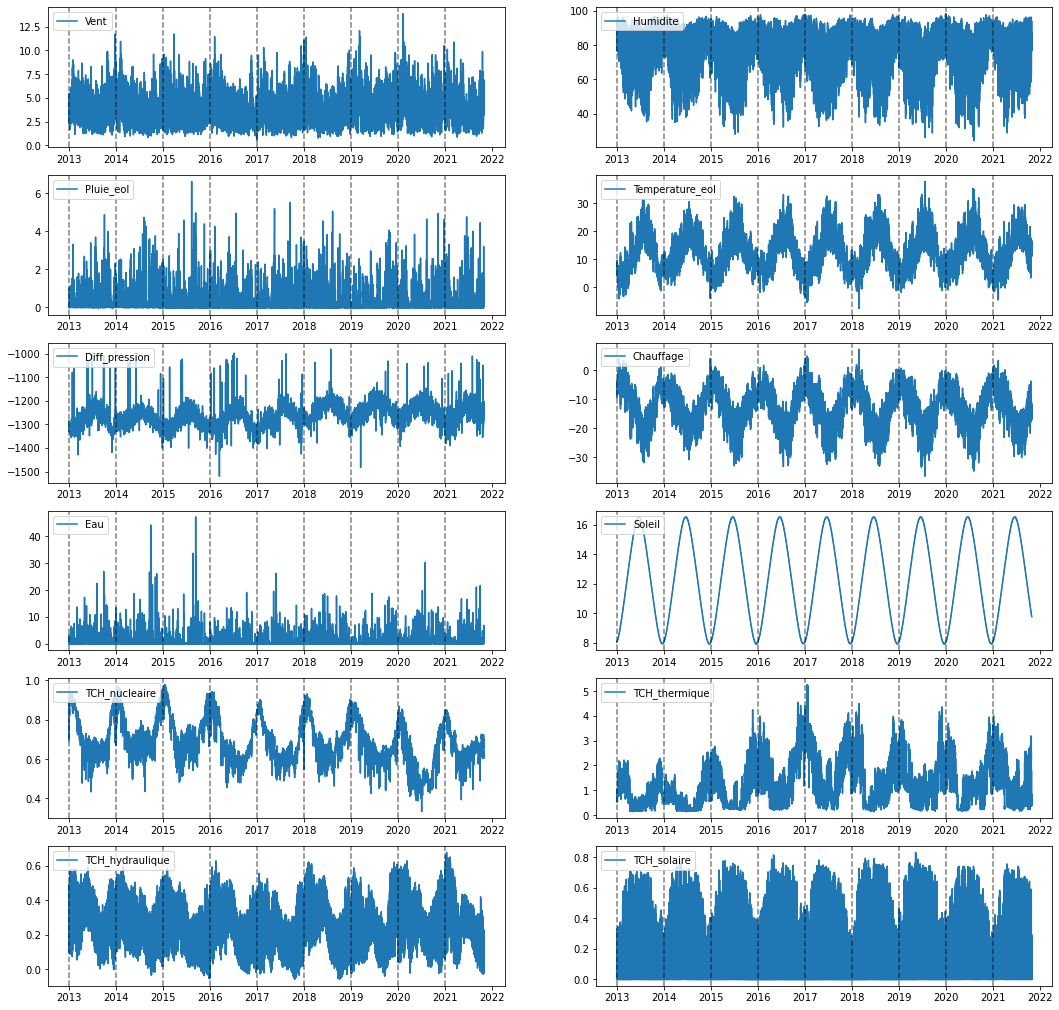

In [63]:
plt.figure(figsize=(18, 18))
for i, variable in enumerate(list_exog):
    plt.subplot(6, 2, i + 1)
    plt.plot(exog_FR_3H[variable], label=variable)
    plt.legend(loc = 'upper left')
    for year in range(2013, 2022):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
plt.savefig('./png/exog_3H.png')

In [64]:
exog_FR_3H.to_csv('./exog/exog_3H_FR.csv', sep = ';')

In [65]:
exog_FR_D = exog_FR_3H.resample('D').mean()
exog_FR_D.to_csv('./exog/exog_D_FR.csv', sep = ';')

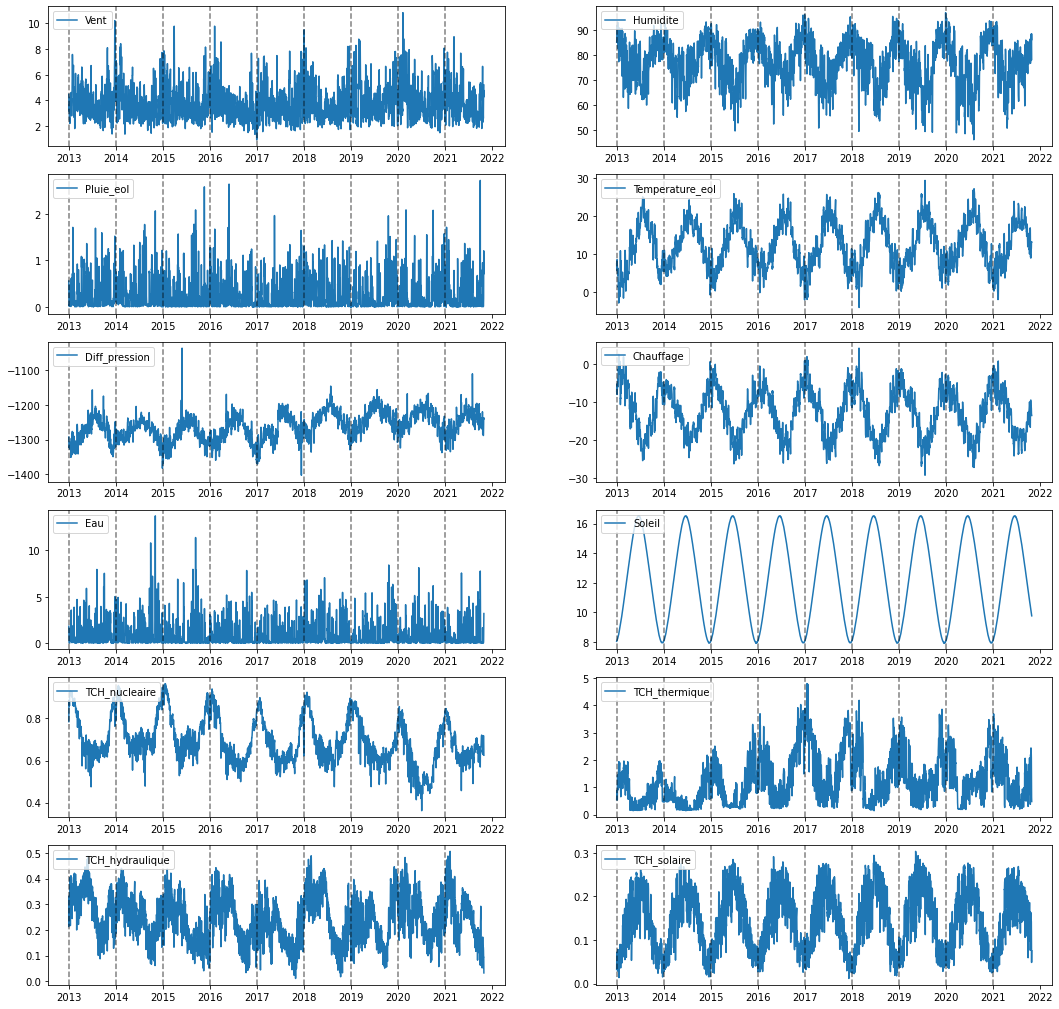

In [66]:
plt.figure(figsize=(18, 18))
for i, variable in enumerate(list_exog):
    plt.subplot(6, 2, i + 1)
    plt.plot(exog_FR_D[variable], label=variable)
    plt.legend(loc = 'upper left')
    for year in range(2013, 2022):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
plt.savefig('./png/exog_D.png')

In [67]:
exog_FR_W = exog_FR_3H.resample('W').mean()
exog_FR_W.to_csv('./exog/exog_W_FR.csv', sep = ';')

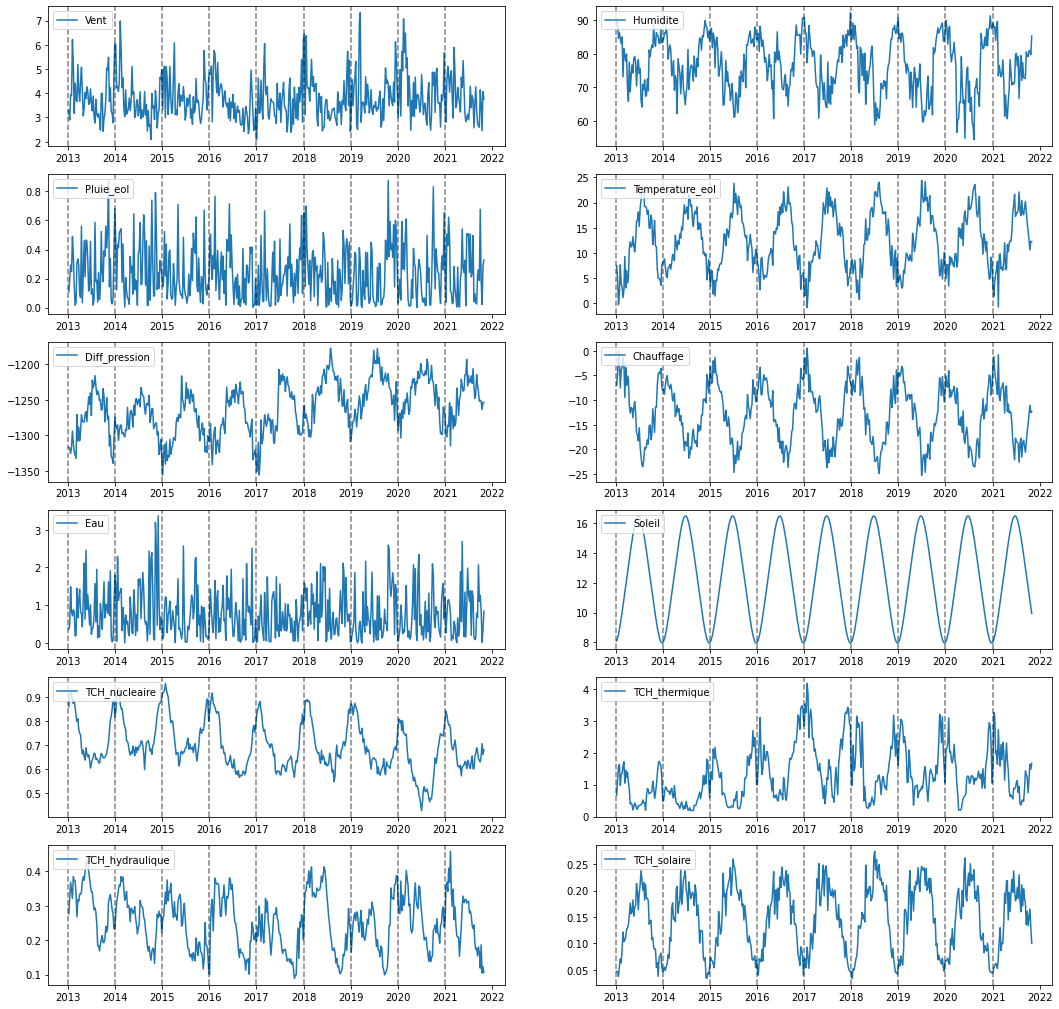

In [68]:
plt.figure(figsize=(18, 18))
for i, variable in enumerate(list_exog):
    plt.subplot(6, 2, i + 1)
    plt.plot(exog_FR_W[variable], label=variable)
    plt.legend(loc = 'upper left')
    for year in range(2013, 2022):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
plt.savefig('./png/exog_W.png')